## LSTM Distilled with Keras

In [1]:
# ========================================================================
#      Deep Learning For Sequential Data and Computer Vision
# ========================================================================
#  Module: Advanced Time Series Models
#  Topic: GRU Distilled with Keras
#    
#  Description:
#  -----------
#  This notebook demonstrates how GRU networks process sequential data by
#  implementing a custom forward pass that replicates Keras' internal GRU
#  computations. We extract weights from a trained Keras GRU model and track
#  the internal states at each time step to build intuition for how GRUs work.
#    
#  Author: Dr. Saad Laouadi
#  Version: 1.0
#    
# ========================================================================
#  ®Copyright Dr. Saad Laouadi, 2025. All rights reserved.
# ========================================================================

In [2]:
# ============================================= #
#           Setting Up Our Environment
# ============================================= #

import numpy as np
import pandas as pd
from tabulate import tabulate

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

%reload_ext watermark

print("*"*52)
%watermark -a "Dr. Saad Laouadi"
%watermark -ud

print("-"*52)
print("The loaded packages".center(52))
print("-"*52)

%watermark -iv
%reload_ext autoreload
%autoreload
print("*"*52)

****************************************************
Author: Dr. Saad Laouadi

Last updated: 2025-03-11

----------------------------------------------------
                The loaded packages                 
----------------------------------------------------
sklearn   : 1.5.2
tabulate  : 0.8.10
tensorflow: 2.16.2
matplotlib: 3.10.0
numpy     : 1.26.4
pandas    : 1.5.3

****************************************************


In [3]:
# ============================================================ #
#         Generate Toy Dataset
# ============================================================ #

# Set seeds for reproducibility
np.random.seed(1010)
tf.random.set_seed(1010)

# Generate our sample data
temperature = np.array([18.2, 19.5, 20.1, 22.4, 23.8, 25.0, 23.2, 21.5, 19.8, 17.5])
humidity = np.array([65.2, 62.8, 58.5, 55.0, 45.2, 42.1, 48.5, 52.3, 60.5, 67.8])
wind_speed = np.array([5.2, 6.8, 8.5, 10.2, 12.5, 14.8, 13.2, 11.5, 9.2, 6.5])
X = np.column_stack((temperature, humidity, wind_speed))

# Target: power consumption (kWh)
y = 2.5 * temperature - 0.5 * humidity + 1.2 * wind_speed + np.random.normal(0, 5, 10)

In [4]:
# Normalize the data
# ==================

# Create scalers for input and output data
X_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the data
X_normalized = X_scaler.fit_transform(X)
y_normalized = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()

# Create sequences with lookback of 2 (predict the step after the sequence)
def create_sequences(X, y, lookback=2):
    X_seq, y_seq = [], []
    for i in range(len(X) - lookback):
        X_seq.append(X[i:i+lookback])
        y_seq.append(y[i+lookback])
    return np.array(X_seq), np.array(y_seq)

X_sequences, y_sequences = create_sequences(X_normalized, y_normalized, lookback=2)

print("=" * 80)
print("GRU IMPLEMENTATION IN KERAS WITH STATE EXTRACTION")
print("=" * 80)
print(f"Data shape: {X.shape} (10 days with 3 features each)")
print(f"Normalized sequence shape: {X_sequences.shape} (8 sequences with lookback=2)")
print("=" * 80)

GRU IMPLEMENTATION IN KERAS WITH STATE EXTRACTION
Data shape: (10, 3) (10 days with 3 features each)
Normalized sequence shape: (8, 2, 3) (8 sequences with lookback=2)


In [5]:
# Define GRU dimensions
n_features = 3  # Temperature, humidity, wind speed
n_hidden = 4    # Number of GRU units (same as previous example)
lookback = 2    # Same as previous example

In [6]:
# Create and compile the model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(lookback, n_features)),
    tf.keras.layers.GRU(n_hidden, 
        return_sequences=False, stateful=False),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Print model summary
print("\nModel Architecture:")
model.summary()


Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 4)              │           108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 113 (452.00 B)

 Trainable params: 113 (452.00 B)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Extract initial weights from the GRU layer
# =================================================

gru_layer = model.layers[0]
gru_weights = gru_layer.get_weights()

# In Keras GRU, weights are organized as:
# [kernel (input weights), recurrent_kernel (hidden state weights), bias]
kernel = gru_weights[0]                    # Input weights (shape: [n_features, n_hidden*3])
recurrent_kernel = gru_weights[1]          # Hidden state weights (shape: [n_hidden, n_hidden*3])
bias = gru_weights[2]                      # Bias terms (shape: [n_hidden*3])

# Keras concatenates all gate weights, so we need to slice them
# The order is: z (update), r (reset), h (candidate)
units = n_hidden
input_dim = n_features

# Extract weights for each gate (reshape to match our earlier format)
# Input weights
W_z_x = kernel[:, :units]
W_r_x = kernel[:, units:units*2]
W_h_x = kernel[:, units*2:units*3]

# Recurrent weights (from previous hidden state)
W_z_h = recurrent_kernel[:, :units]
W_r_h = recurrent_kernel[:, units:units*2]
W_h_h = recurrent_kernel[:, units*2:units*3]

# Bias terms
b_z = bias[:units]
b_r = bias[units:units*2]
b_h = bias[units*2:units*3]

print("+"*62)
print("Extracted GRU Weights:".center(62))
print("+"*62)
print(f"{'Update gate weights (W_z_x):':<35} {W_z_x.shape}")
print(f"{'Reset gate weights (W_r_x):':<35} {W_r_x.shape}")
print(f"{'Candidate weights (W_h_x):':<35} {W_h_x.shape}")
print(f"{'Recurrent weights shapes:':<35} {W_z_h.shape, W_r_h.shape, W_h_h.shape}")
print('+'*62)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                    Extracted GRU Weights:                    
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Update gate weights (W_z_x):        (3, 4)
Reset gate weights (W_r_x):         (3, 4)
Candidate weights (W_h_x):          (3, 4)
Recurrent weights shapes:           ((4, 4), (4, 4), (4, 4))
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


In [8]:
# Extract initial weights from the GRU layer
gru_layer = model.layers[0]
gru_weights = gru_layer.get_weights()

# In Keras GRU, weights are organized as:
# [kernel (input weights), recurrent_kernel (hidden state weights), bias]
kernel = gru_weights[0]         # Input weights (shape: [n_features, n_hidden*3])
recurrent_kernel = gru_weights[1]   # Hidden state weights (shape: [n_hidden, n_hidden*3])
bias = gru_weights[2]           # Bias terms (shape: [n_hidden*3])

# The order is: z (update), r (reset), h (candidate)
units = n_hidden

# Input weights for each part of the GRU
W_z_x = kernel[:, :units]
W_r_x = kernel[:, units:units*2]
W_h_x = kernel[:, units*2:units*3]

# Recurrent weights for each part of the GRU
W_z_h = recurrent_kernel[:, :units]
W_r_h = recurrent_kernel[:, units:units*2]
W_h_h = recurrent_kernel[:, units*2:units*3]

# Bias terms - THIS IS THE PART THAT NEEDS FIXING
# In Keras, for GRU, bias is organized as [b_z, b_r, b_h] with each having shape [units]
# and total bias has shape [units*3]
b_z = bias[:units]
b_r = bias[units:units*2]
b_h = bias[units*2:units*3]

# Print to verify the new shapes
print("Bias shapes after correction:")
print(f"b_z shape: {b_z.shape}")
print(f"b_r shape: {b_r.shape}")
print(f"b_h shape: {b_h.shape}")

Bias shapes after correction:
b_z shape: (2, 12)
b_r shape: (0, 12)
b_h shape: (0, 12)


In [9]:
# ================================================================ #
#        Implement FF GRU with Keras
# ================================================================ #

# Define activation functions (same as previous example)
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

# Custom forward pass to replicate Keras's internal GRU computation
def gru_forward_pass(X_sequences, weights):
    kernel, recurrent_kernel, bias = weights
    n_sequences = X_sequences.shape[0]
    predictions = np.zeros(n_sequences)
    
    # Extract weights properly
    W_z_x = kernel[:, :n_hidden]
    W_r_x = kernel[:, n_hidden:n_hidden*2]
    W_h_x = kernel[:, n_hidden*2:n_hidden*3]
    
    W_z_h = recurrent_kernel[:, :n_hidden]
    W_r_h = recurrent_kernel[:, n_hidden:n_hidden*2]
    W_h_h = recurrent_kernel[:, n_hidden*2:n_hidden*3]
    
    # Extract biases properly from the first row (input bias)
    input_bias = bias[0]
    b_z = input_bias[:n_hidden]
    b_r = input_bias[n_hidden:2*n_hidden]
    b_h = input_bias[2*n_hidden:3*n_hidden]
    
    # Initialize hidden state
    h_t = np.zeros(n_hidden)
    
    all_states = []
    
    for seq_idx, sequence in enumerate(X_sequences):
        print(f"\n{'=' * 30} SEQUENCE {seq_idx+1} {'=' * 30}")
        print(f"Days {seq_idx+1}-{seq_idx+2} → Predicting Day {seq_idx+3}")
        
        sequence_states = []
        
        for t in range(len(sequence)):
            x_t = sequence[t]
            day_num = seq_idx + t + 1
            
            # Calculate gate inputs
            # Input contribution to gates
            z_input = np.dot(x_t, W_z_x)
            r_input = np.dot(x_t, W_r_x)
            h_input = np.dot(x_t, W_h_x)
            
            # Hidden state contribution to gates
            z_hidden = np.dot(h_t, W_z_h)
            r_hidden = np.dot(h_t, W_r_h)
            
            # Gate activations with bias
            z_t = sigmoid(z_input + z_hidden + b_z)
            r_t = sigmoid(r_input + r_hidden + b_r)
            
            # Calculate reset hidden state
            reset_h_t = r_t * h_t
            
            # Calculate candidate hidden state
            h_hidden = np.dot(reset_h_t, W_h_h)
            h_tilde = tanh(h_input + h_hidden + b_h)
            
            # Update hidden state
            h_t_prev = h_t.copy()
            h_t = (1 - z_t) * h_t + z_t * h_tilde
            
            # Store states
            sequence_states.append({
                'day': day_num,
                'input': x_t,
                'update_gate': z_t,
                'reset_gate': r_t,
                'candidate_hidden': h_tilde,
                'hidden_state': h_t.copy()
            })
            
            # Print gate values and states for this time step
            print(f"\n--- Time step {t+1} (Day {day_num}) ---")
            print("Input Features:")
            input_table = [
                ["Temperature", f"{x_t[0]:.2f}"],
                ["Humidity", f"{x_t[1]:.2f}"],
                ["Wind Speed", f"{x_t[2]:.2f}"]
            ]
            print(tabulate(input_table, headers=["Feature", "Value"], tablefmt="grid"))
            
            print("\nGate Values:")
            gates_table = [
                ["Update Gate (z_t)", f"{z_t}"],
                ["Reset Gate (r_t)", f"{r_t}"],
                ["Candidate Hidden State (h_tilde)", f"{h_tilde}"]
            ]
            print(tabulate(gates_table, headers=["Gate", "Values"], tablefmt="grid"))
            
            print("\nState Updates:")
            state_table = [
                ["Previous Hidden State", f"{h_t_prev}"],
                ["New Hidden State", f"{h_t}"],
                ["Change in Hidden State", f"{h_t - h_t_prev}"]
            ]
            print(tabulate(state_table, headers=["State", "Values"], tablefmt="grid"))
        
        # Predict using the final hidden state (replicating Dense layer)
        W_y = model.layers[1].get_weights()[0]
        b_y = model.layers[1].get_weights()[1]
        y_pred = np.dot(h_t, W_y) + b_y
        predictions[seq_idx] = y_pred[0]
        
        # Print prediction vs actual
        # Convert back to original scale for clearer comparison
        original_pred = y_scaler.inverse_transform([[y_pred[0]]])[0][0]
        original_actual = y_scaler.inverse_transform([[y_sequences[seq_idx]]])[0][0]
        
        print(f"\n--- Prediction for Day {seq_idx+3} ---")
        pred_table = [
            ["Predicted Power Consumption (normalized)", f"{y_pred[0]:.4f}"],
            ["Actual Power Consumption (normalized)", f"{y_sequences[seq_idx]:.4f}"],
            ["Prediction Error (normalized)", f"{y_pred[0] - y_sequences[seq_idx]:.4f}"],
            ["Predicted Power Consumption (kWh)", f"{original_pred:.2f}"],
            ["Actual Power Consumption (kWh)", f"{original_actual:.2f}"],
            ["Prediction Error (kWh)", f"{original_pred - original_actual:.2f}"]
        ]
        print(tabulate(pred_table, headers=["Metric", "Value"], tablefmt="grid"))
        
        all_states.append(sequence_states)
        
        print(f"\nFinal state after sequence {seq_idx+1}:")
        final_state_table = [
            ["Hidden State (h_t)", f"{h_t}"]
        ]
        print(tabulate(final_state_table, headers=["State", "Values"], tablefmt="grid"))
        
        if seq_idx < len(X_sequences) - 1:
            print("\n→ This state will be used as initial state for the next sequence")
    
    return predictions, all_states

# Run our custom forward pass
print("\n" + "=" * 80)
print("CUSTOM FORWARD PASS USING EXTRACTED WEIGHTS")
print("=" * 80)
predictions, all_states = gru_forward_pass(X_sequences, gru_weights)

# Compare with Keras model predictions
keras_predictions = model.predict(X_sequences, verbose=0)

print("\n" + "=" * 80)
print("COMPARISON WITH KERAS MODEL PREDICTIONS")
print("=" * 80)
comparison_table = []
for i in range(len(predictions)):
    # Original scale values
    orig_pred = y_scaler.inverse_transform([[predictions[i]]])[0][0]
    orig_keras = y_scaler.inverse_transform([[keras_predictions[i][0]]])[0][0]
    orig_actual = y_scaler.inverse_transform([[y_sequences[i]]])[0][0]
    
    comparison_table.append([
        i+3,  # Day number (after lookback)
        f"{predictions[i]:.4f}",
        f"{keras_predictions[i][0]:.4f}",
        f"{y_sequences[i]:.4f}",
        f"{orig_pred:.2f}",
        f"{orig_keras:.2f}",
        f"{orig_actual:.2f}"
    ])

print(tabulate(comparison_table, 
               headers=["Day", "Our Pred (norm)", "Keras Pred (norm)", "Actual (norm)", 
                        "Our Pred (kWh)", "Keras Pred (kWh)", "Actual (kWh)"], 
               tablefmt="grid"))

print("\nNote: Our predictions and Keras predictions might differ slightly due to")
print("implementation details and numerical precision differences.")


CUSTOM FORWARD PASS USING EXTRACTED WEIGHTS

============================== SEQUENCE 1 ==============================
Days 1-2 → Predicting Day 3

--- Time step 1 (Day 1) ---
Input Features:
+-------------+---------+
| Feature     |   Value |
+=============+=========+
| Temperature |    0.09 |
+-------------+---------+
| Humidity    |    0.9  |
+-------------+---------+
| Wind Speed  |    0    |
+-------------+---------+

Gate Values:
+----------------------------------+---------------------------------------------------+
| Gate                             | Values                                            |
+==================================+===================================================+
| Update Gate (z_t)                | [0.38698857 0.61055616 0.62631871 0.50622132]     |
+----------------------------------+---------------------------------------------------+
| Reset Gate (r_t)                 | [0.51514902 0.52504975 0.41742289 0.56215974]     |
+-------------------------

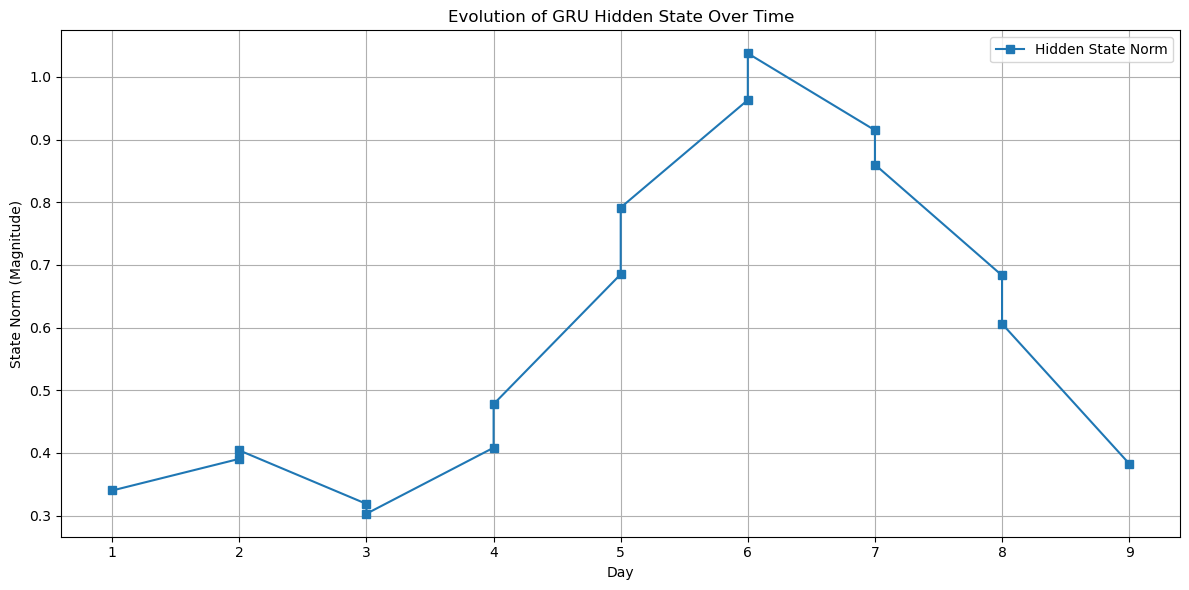

In [10]:
# Visualize the state evolution
days = []
hidden_state_norms = []

for seq_idx, sequence_states in enumerate(all_states):
    for state in sequence_states:
        days.append(state['day'])
        hidden_state_norms.append(np.linalg.norm(state['hidden_state']))

plt.figure(figsize=(12, 6))
plt.plot(days, hidden_state_norms, 's-', label='Hidden State Norm')
plt.xlabel('Day')
plt.ylabel('State Norm (Magnitude)')
plt.title('Evolution of GRU Hidden State Over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
# plt.savefig('gru_state_evolution.png')
# plt.close()
plt.show()

In [11]:
print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)
print("The code has successfully:")
print("1. Created a GRU model in Keras with the same architecture")
print("2. Extracted the weights from the Keras model")
print("3. Implemented a custom forward pass to show the internal calculations")
print("4. Compared our predictions with the Keras model predictions")
print("5. Generated a visualization of how the hidden state evolves over time")
print("\nA plot of state evolution has been saved as 'gru_state_evolution.png'")


SUMMARY
The code has successfully:
1. Created a GRU model in Keras with the same architecture
2. Extracted the weights from the Keras model
3. Implemented a custom forward pass to show the internal calculations
4. Compared our predictions with the Keras model predictions
5. Generated a visualization of how the hidden state evolves over time

A plot of state evolution has been saved as 'gru_state_evolution.png'


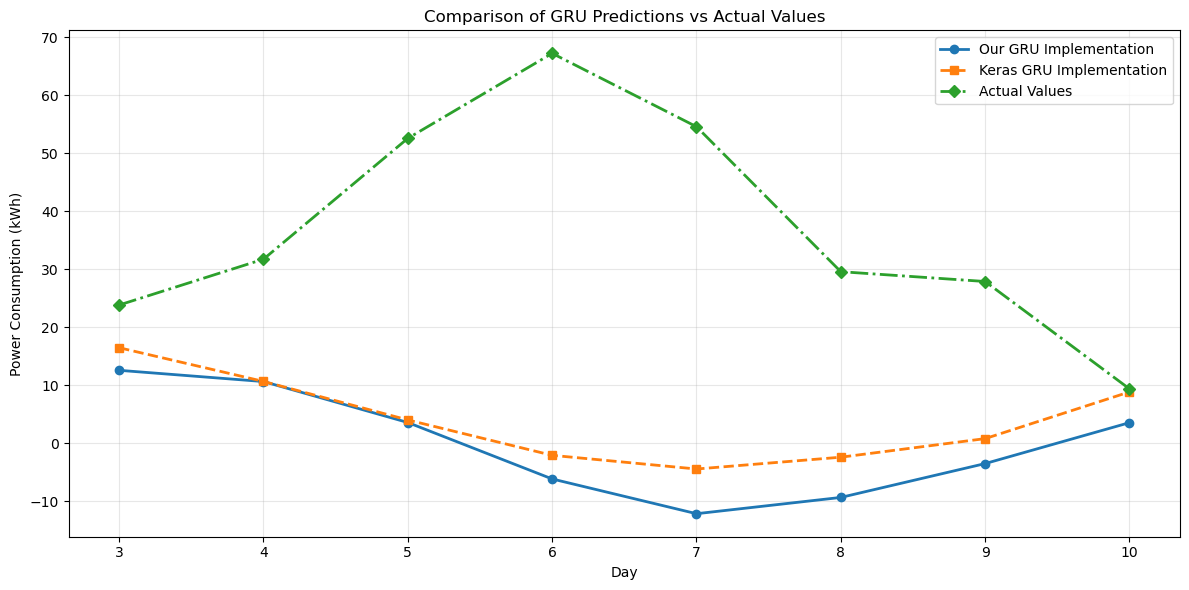

In [12]:
# A comparison of the two approaches visualization
# Plot the predictions in original scale
plt.figure(figsize=(12, 6))
days = list(range(3, 3 + len(predictions)))
orig_preds = [y_scaler.inverse_transform([[p]])[0][0] for p in predictions]
orig_keras = [y_scaler.inverse_transform([[k[0]]])[0][0] for k in keras_predictions]
orig_actual = [y_scaler.inverse_transform([[a]])[0][0] for a in y_sequences]

plt.plot(days, orig_preds, 'o-', label='Our GRU Implementation', linewidth=2)
plt.plot(days, orig_keras, 's--', label='Keras GRU Implementation', linewidth=2)
plt.plot(days, orig_actual, 'D-.', label='Actual Values', linewidth=2)
plt.xlabel('Day')
plt.ylabel('Power Consumption (kWh)')
plt.title('Comparison of GRU Predictions vs Actual Values')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(days)
plt.tight_layout()
plt.show()